(1.024714824779271, -5.946854551135288)

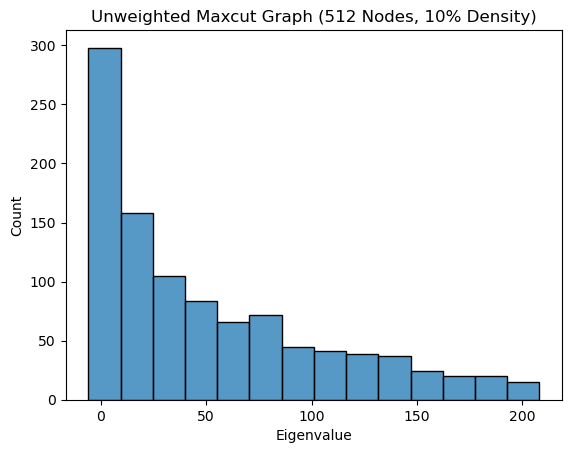

In [2]:
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
from tqdm import tqdm
device = 'cuda:0'
G = nx.erdos_renyi_graph(n=1024, p=.1)

while nx.is_connected(G) == False:
    G = nx.erdos_renyi_graph(n=64, p=.1)
edges = np.random.choice([-1,1], G.number_of_edges())
for i, e in enumerate(G.edges()):
    G.edges[e[0], e[1]]['weight'] = edges[i]
# G = nx.convert_node_labels_to_integers(nx.grid_2d_graph(n=20, m=20, periodic=True))
# eweights = G.edges()
order = np.random.choice(np.arange(G.number_of_nodes()), size=G.number_of_nodes(), replace=False)
A = -torch.tensor(nx.to_numpy_array(G, order, weight='weight'), device=device)
blocks = np.array_split(np.arange(G.number_of_nodes()), 2)
B = G.number_of_nodes() // len(blocks)
JInternal = torch.block_diag(*[A[np.ix_(b,b)] for b in blocks] )
JExt = A - JInternal
eig = torch.linalg.eigh(JInternal)
vals = torch.linalg.eigvals(A@JExt).cpu().numpy().real
# vals = np.abs(vals[np.abs(vals) > 1])

ax = sns.histplot(vals)
ax.set_xlabel('Eigenvalue')
ax.set_title('Unweighted Maxcut Graph (512 Nodes, 10% Density)')
vals[0] / vals[1], vals.min()

In [ ]:
import igraph as ig
def make_sparse_graph_operator(matrix: torch.Tensor, hops: torch.Tensor, blocks: torch.Tensor):
    block_inds = np.zeros(matrix.shape[0]).astype(int)
    b = len(blocks)
    hmax = int(hops.max()) + 1
    B = matrix.shape[0] // b
    blockvals = [[[0 for i in range(B)] for i in range(B)] for k in range(b*hmax)]
    print(blocks)
    N = matrix.shape[0]
    for i, blck in enumerate(blocks):
        for x in blck:
            block_inds[x] = i
    for u in range(N):
        print(u,v)
        bu = block_inds[u]
        bv = block_inds[v]
        blockvals[hops[bu, bv]*b + bv][u-bu*B][v-bv*B] = -d['weight']
        blockvals[hops[bv, bu]*b + bu][v-bv*B][u-bu*B] = -d['weight']

    mat = torch.sparse_bsc_tensor(ccol_indices=[*np.arange(b*hmax), b*hmax], row_indices=np.tile(), values=blockvals ).to_sparse_bsr(matrix.shape[0] // b).double().to(device)
    return mat
mat = torch.randn(1000, 1000)
mat = (mat + mat.T) / 2
connG = nx.Graph()
connG.add_nodes_from(np.arange(4))
connG.add_edge(0, 1)
connG.add_edge(1, 2)
connG.add_edge(2, 3)
connG.add_edge(3, 0)
connG.add_edge(0, 1)
gig = ig.Graph.from_networkx(connG)
apsp = torch.tensor(gig.distances())
blocks = torch.tensor(np.array_split(np.arange(mat.shape[0]), connG.number_of_nodes()))
make_sparse_graph_operator(mat, apsp, blocks)

tensor([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
         126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
         140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
         154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
         168, 169, 170, 171, 172, 173, 174, 175, 176

IndexError: index 1007 is out of bounds for axis 0 with size 1000

In [11]:
extvals = torch.linalg.eigvalsh(JExt)
intvals = torch.linalg.eigvalsh(JInternal)
2/((abs(extvals[0]) - abs(intvals[0])) / (50e-15*310e3*2))

tensor(-2.2694e-08, device='cuda:0', dtype=torch.float64)

In [12]:
inds = np.argsort(np.abs(eig.eigenvalues.cpu())).numpy()[::-1]
inds[0:5]
maxeigs = eig.eigenvectors[:,list(inds[0:100])].T


In [13]:
eigs = eig.eigenvectors

<Axes: >

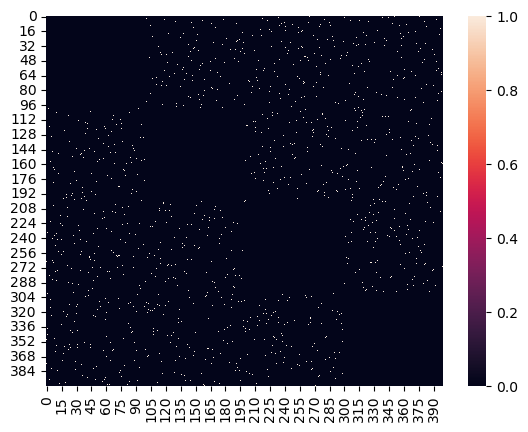

In [22]:
sns.heatmap(JExt.cpu().abs())

<Axes: >

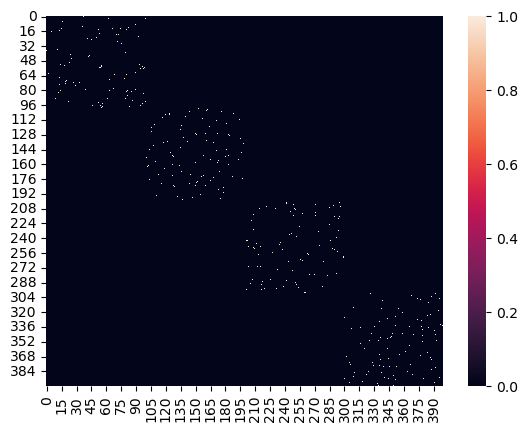

In [23]:
sns.heatmap(JInternal.cpu().abs())

-1.9560682028578622

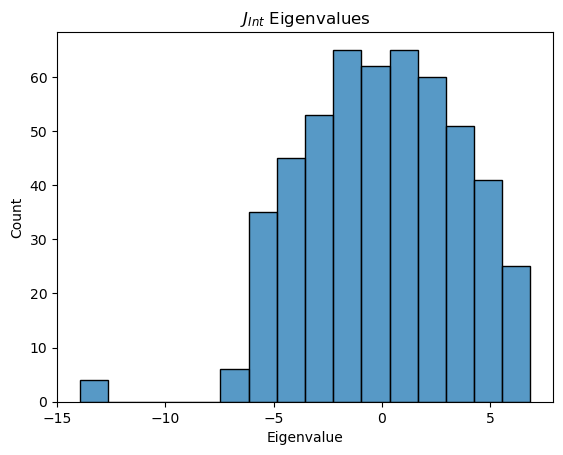

In [59]:

vals = torch.linalg.eigvals(JInternal ).cpu().numpy().real
# vals = np.abs(vals[np.abs(vals) > 1])

ax=sns.histplot(vals)
ax.set_xlabel('Eigenvalue')
ax.set_title('$J_{Int}$ Eigenvalues')
vals[0] / vals[1]

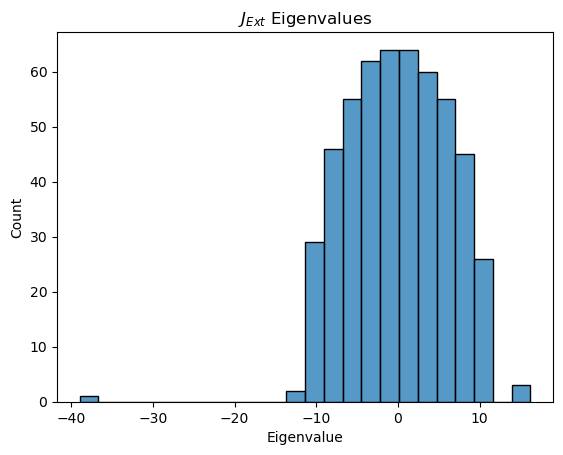

In [60]:

vals = torch.linalg.eigvals(JExt).cpu().numpy().real
# vals = np.abs(vals[np.abs(vals) > |1])

ax=sns.histplot(vals)
ax.set_xlabel('Eigenvalue')
ax.set_title('$J_{Ext}$ Eigenvalues')
vals[0] / vals[1]
eig = torch.linalg.eigh(JExt)
leading_eig = eig.eigenvectors[:,0]

In [35]:
torch.linalg.eigvals(JInternal + 0*torch.eye(G.number_of_nodes(), device=device)).cpu().numpy().real.min()

-13.75320956112951

-13.75320956112951
1.2467904388704958
16.246790438870512


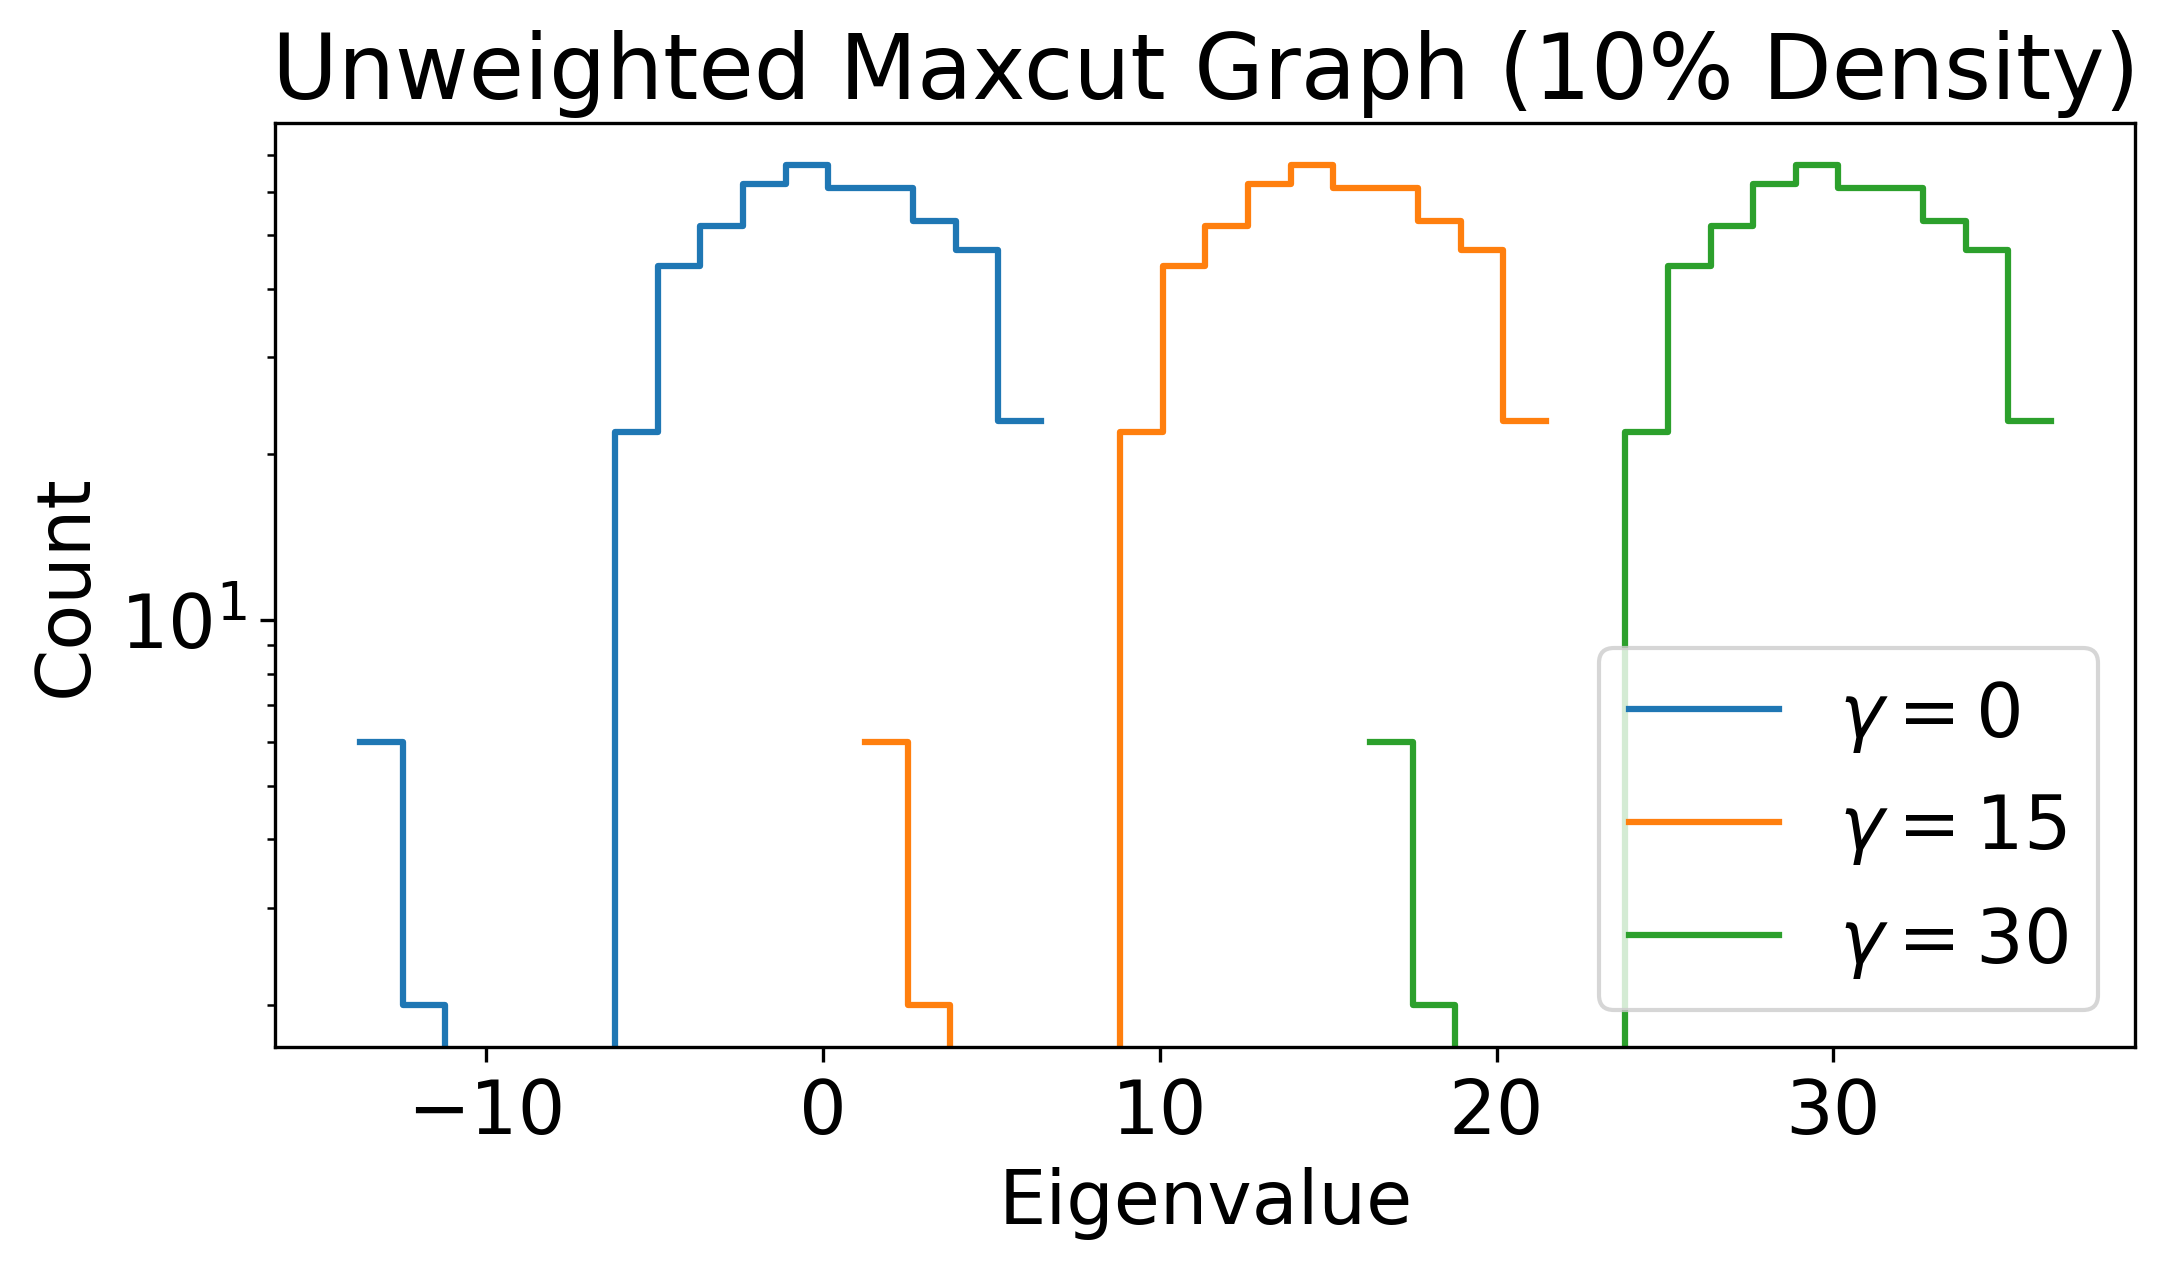

In [32]:
eig = torch.linalg.eigh(A)
vals = torch.linalg.eigvals(JInternal + 0*torch.eye(G.number_of_nodes(), device=device)).cpu().numpy().real
# vals = np.abs(vals[np.abs(vals) > 1])
import matplotlib as mpl
mpl.rcParams['font.size']=18
fig, ax = plt.subplots(ncols=1, dpi=300, figsize=(8,4))

print(vals.min())
sns.histplot(vals, ax=ax, element='step',fill=False, label='$\\gamma=0$')
ax.set_xlabel('Eigenvalue Magnitude')
vals = torch.linalg.eigvals(JInternal + 12*torch.eye(G.number_of_nodes(), device=device)).cpu().numpy().real
# vals = np.abs(vals[np.abs(vals) > 1])
print(vals.min())
sns.histplot(vals, ax=ax, element='step',fill=False,label='$\\gamma=15$')
ax.set_xlabel('Eigenvalue Magnitude')
vals = torch.linalg.eigvals(JInternal + 30*torch.eye(G.number_of_nodes(), device=device)).cpu().numpy().real
print(vals.min())
# vals = np.abs(vals[np.abs(vals) > 1])
sns.histplot(vals, ax=ax, element='step',fill=False,label='$\\gamma=30$')
ax.set_xlabel('Eigenvalue')
ax.set_title('Unweighted Maxcut Graph (10% Density)')
ax.set_yscale('log')
ax.legend()

In [3]:
torch.linalg.inv(JInternal)

tensor([[-0.0113, -0.3446,  0.1864,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3446, -0.0113,  0.1864,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1864,  0.1864, -0.5763,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.0000, -0.0000, -0.0000,  ...,  7.7778,  3.4444, -5.2222],
        [-0.0000, -0.0000, -0.0000,  ...,  3.4444,  1.1111, -2.5556],
        [ 0.0000,  0.0000,  0.0000,  ..., -5.2222, -2.5556,  3.7778]],
       device='cuda:0', dtype=torch.float64)

1.004388531211298

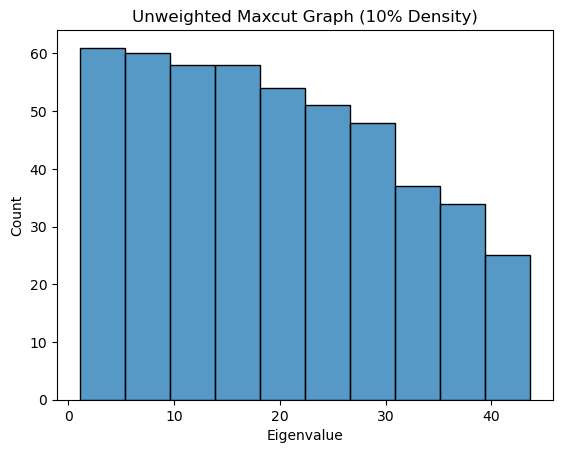

In [4]:

G = nx.erdos_renyi_graph(n=500, p=1)
while nx.is_connected(G) == False:
    G = nx.erdos_renyi_graph(n=500, p=1)
edges = np.random.choice([-1,1], G.number_of_edges())
for i, e in enumerate(G.edges()):
    G.edges[e[0], e[1]]['weight'] = edges[i]

# eweights = G.edges()
A = -torch.tensor(nx.to_numpy_array(G, np.arange(G.number_of_nodes()), weight='weight'), device=device)
blocks = np.array_split(np.arange(G.number_of_nodes()), 8)
JInternal = torch.block_diag(*[A[np.ix_(b,b)] for b in blocks] )
JExt = A - JInternal
eig = torch.linalg.eigh(A)
vals = torch.linalg.eigvals(A).cpu().numpy().real
vals = np.abs(vals[np.abs(vals) > 1])

ax=sns.histplot(vals)
ax.set_xlabel('Eigenvalue')
ax.set_title('Unweighted Maxcut Graph (10% Density)')
vals[0] / vals[1]

In [183]:
x0 = torch.randn((G.number_of_nodes(), 1), device=device).clip(-1, 1).double()
x0[x0 > 0]  = 1
x0[x0 < 0]  = -1


tensor(0.6313)

In [61]:

R = 310e3
C = 50e-15
blocks = np.array_split(np.arange(G.number_of_nodes()), 4)
JInternal = torch.block_diag(*[A[np.ix_(b,b)] for b in blocks] )
x0 = torch.randn((G.number_of_nodes(), 1), device=device).clip(-1, 1).double().sign()
print(x0.mean())
eig = torch.linalg.eigh(JExt)
maxind = torch.argmax(torch.einsum("ij,ik->jk", eig.eigenvectors, x0), dim=0)
# print(maxind.shape)
maxeig = eig.eigenvectors[:, maxind]
def concurrent_langevin(G, J:torch.tensor, x0:torch.tensor, blocks, time: float, dt: float, sync_epoch: float, gamma=20, gamma_min=5, T=1):
    JInternal = torch.block_diag(*[J[np.ix_(b,b)] for b in blocks] )
    JExt = J - JInternal
    L = torch.linalg.eigvalsh(JInternal).abs().max()
    M = torch.linalg.eigvalsh(JExt).abs().max()
    eigmax = torch.linalg.eigh(JExt)
    vec = eigmax.eigenvectors[:,0]
    # x0 = vec.unsqueeze(1)
    prob_bound = sync_epoch * (M-L) / ((R*C))
    cdf = (0.5 + 0.5 * torch.erf((prob_bound)/np.sqrt(4 * sync_epoch * T / (R * C))))
    print( prob_bound.item() * (1-np.sqrt(sync_epoch / (R*C) * 2 * T)))
    tsteps = int(np.ceil(time / dt))
    sched = torch.linspace(T, T, tsteps)
    sync_steps = int(np.ceil(sync_epoch / dt))
    x_copy = x0.clone().detach().sign()
    x = x0.clone().detach()
    prev_noise = torch.randn_like(x)
    sumW = -A.sum() / 2
    vals = []
    vals_copy = []
    prox = []
    gamma_sched = torch.linspace(gamma, gamma_min, tsteps)
    print(x0.sign().mean())
    for i in tqdm(range(tsteps)):
        next_noise = torch.randn_like(x)
        xs = x.sign()
        xcs = x_copy.sign()
        # grad1 = (1 + gamma_sched[i])*JInternal.matmul(xs)
        grad1 = JInternal.matmul(xs)
        grad2 = JExt.matmul(x_copy)
        
        x = torch.clip(x + dt * torch.tanh(grad1 + grad2) + sched[i] * np.sqrt(dt) * (next_noise), -1, 1)
        prev_noise = next_noise
        if i % sync_steps == 0:
            x_copy = x.sign()
        prox.append(grad2.norm(dim=1).mean().item())
        # cut = (sumW + 0.5*x.sign().T.matmul(J.matmul(xs.sign()))) / 2
        ene = -0.5*x.sign().T.matmul(J.matmul(x.sign()))
        vals.append(((ene).mean().item()))
        vals_copy.append(((xs.sign()).mean().item()))
        # vals_copy.append(cut_other.mean().item())

    return x, np.array(vals), np.array(vals_copy), np.array(prox)

def concurrent_langevin_graph(G, J:torch.Tensor, x0:torch.Tensor, blocks, time: float, dt: float, sync_epoch: float, hops: torch.Tensor, T0: float, T1: float = None):
    if T1 is None:
        T1 = T0
    JExt = make_sparse_graph_operator(J, hops)
    # x0 = vec.unsqueeze(1)
    tsteps = int(np.ceil(time / dt))
    sched = torch.linspace(T0, T1, tsteps)
    sync_steps = int(np.ceil(sync_epoch / dt))
    state = torch.tile(x0, (1,3)).sign()
    x = x0.clone().detach()
    prev_noise = torch.randn_like(x)
    sumW = -J.sum() / 2
    for i in tqdm(range(tsteps)):
        next_noise = torch.randn_like(x)
        # grad1 = (1 + gamma_sched[i])*JInternal.matmul(xs)
        grad = JInternal.matmul(torch.concatenate())
        grad2 = JExt.matmul(x_copy)
        
        x = torch.clip(x + dt/(R*C) * torch.tanh(grad1 + grad2 +  gamma_sched[i] * x) + sched[i] * np.sqrt(dt/( R*C)) * (prev_noise + next_noise), -1, 1)
        prev_noise = next_noise
        if i % sync_steps == 0:
            state = torch.roll(state, x.shape[0])
            state[0:x.shape[0]] = x.sign()

        prox.append(grad2.norm(dim=1).mean().item())
        cut = (sumW + 0.5*x.sign().T.matmul(J.matmul(xs.sign()))) / 2
        vals_copy.append(x.abs().mean().cpu().numpy())
        vals.append(((cut).mean().item()))
        # vals_copy.append(cut_other.mean().item())

    return x, np.array(vals), np.array(vals_copy), np.array(prox)
    # print(Jblock)
# x0 = torch.randn((G.number_of_nodes(),)).clip(-1, 1).double()
# data = []
# for i in tqdm(np.linspace(1e-3, 3, 20)):
#     for t in range(20):
#         spins = concurrent_langevin(A, x0, np.array_split(np.arange(G.number_of_nodes()), 4), 10, 1e-3, i)
#         spins = (spins > 0).int() -( spins < 0).int()
#         S = [i for i, s in enumerate(spins) if s == 1]
#         cut = nx.cut_size(G, S)
#         data.append((i, cut, t))
hops = torch.tensor(
        [[0, 1, 1, 2],
        [1, 0, 2, 1],
        [1, 2, 0, 1],
        [2, 1, 1, 0],]
    ).int()
x1, v1, vc2, p1 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 1), 10, 1e-3, 1e-3, 0,0, np.sqrt(2 * 2.0))
# x1, v2, vc6, p5 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 1), 1e-6, 1e-11, 1e-9, 30, 5, 0.5)
# x1, v3, vc7, p5 = concurrent_langevin(G, A, x0, blocks, 1e-7, 1e-11, 100e-9, 0, 0, 0.5)

tensor(-0.0700, device='cuda:0', dtype=torch.float64)
130838840.7743902
tensor(-0.0700, device='cuda:0', dtype=torch.float64)


100%|██████████| 10000/10000 [00:01<00:00, 7782.04it/s]


/tmp/ipykernel_14874/1560516768.py:2: RuntimeWarning: Mean of empty slice.
  (v1[20000:] / 400).mean()
/home/matt/miniconda3/envs/rbm/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


nan

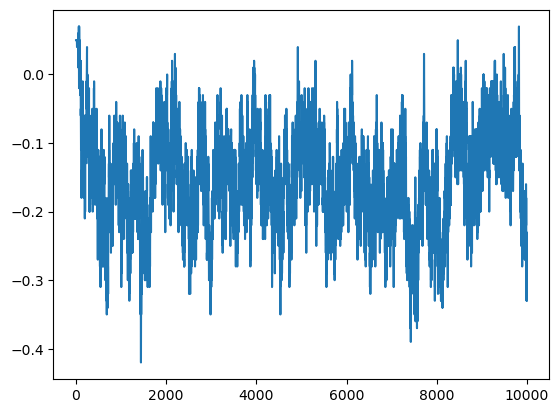

In [62]:
sns.lineplot(v1 / 400)
(v1[20000:] / 400).mean()

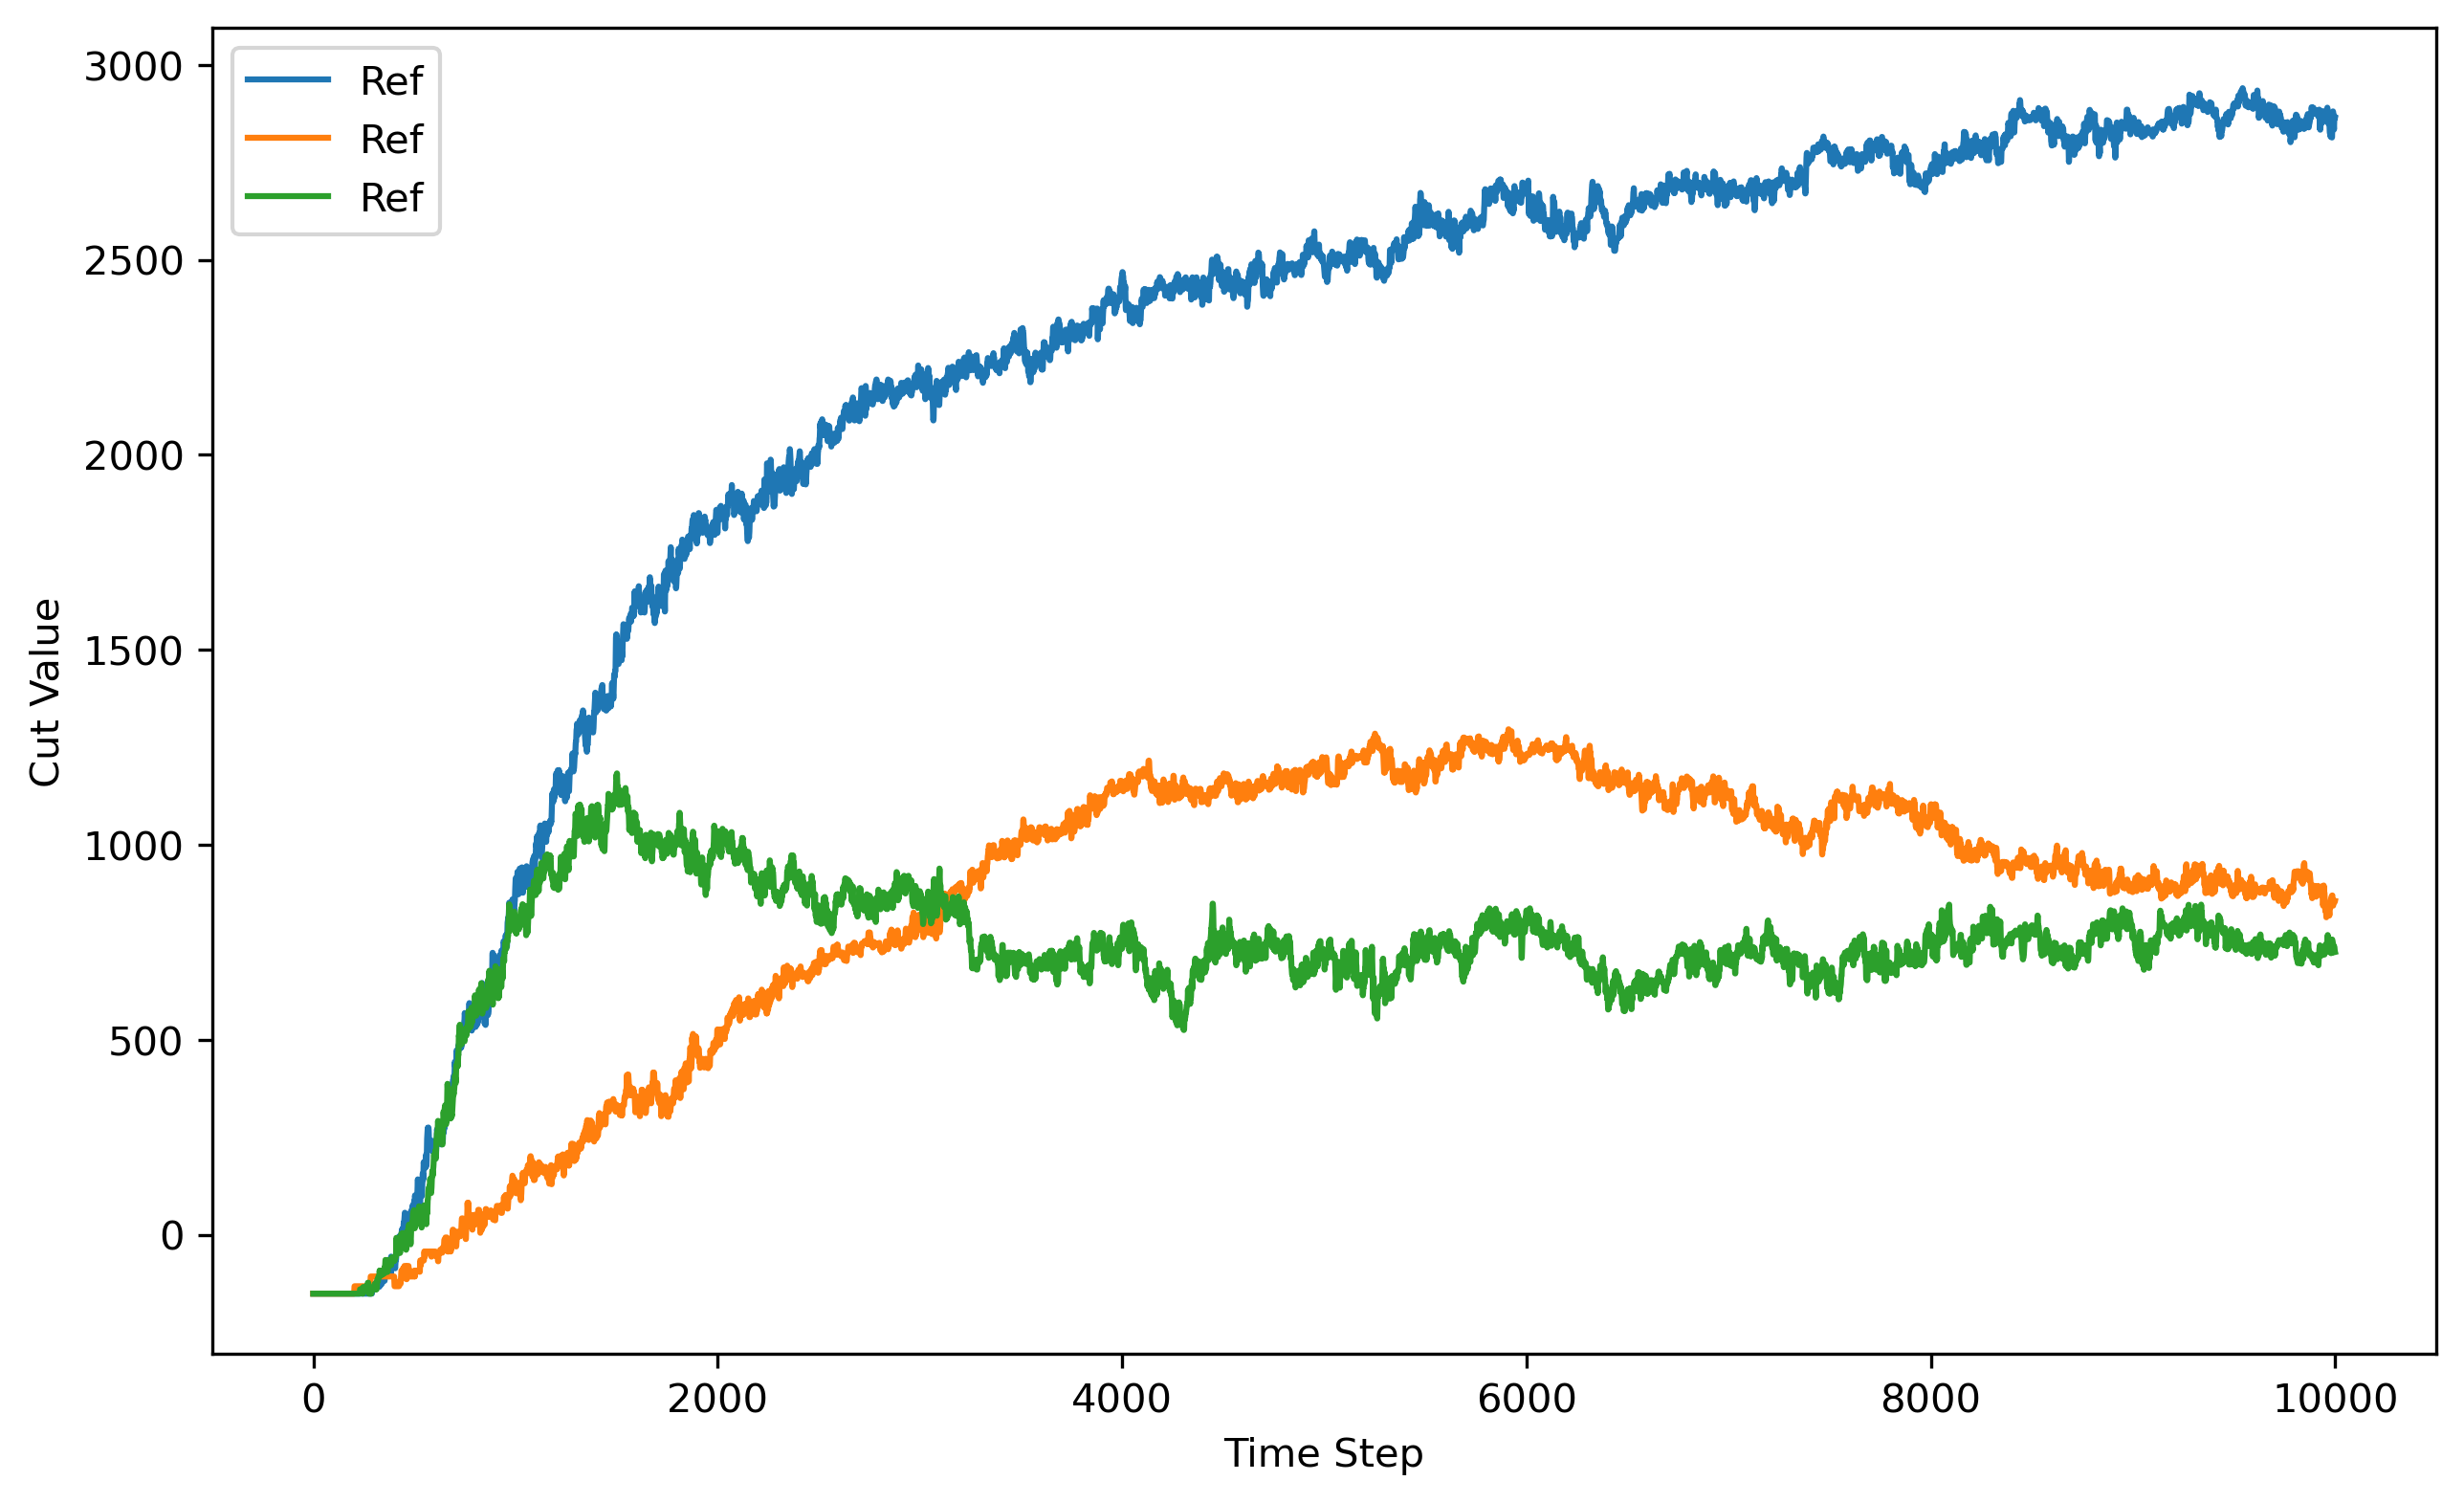

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=300, figsize=(10, 6))
ax = sns.lineplot(x=np.arange(len(v3)), y=v1, label='Ref')
ax = sns.lineplot(x=np.arange(len(v3)), y=v2, label='Ref')
ax = sns.lineplot(x=np.arange(len(v3)), y=v3, label='Ref')
ax.set_ylabel('Cut Value')
# ax.set_ylabel('Degenerate State Overlap')
ax.set_xlabel('Time Step')
# ax.set_yscale('log')
# ax.set_yscale('log')
ax.legend()

# [np.var(i) for i in [v2, v3, v4]]

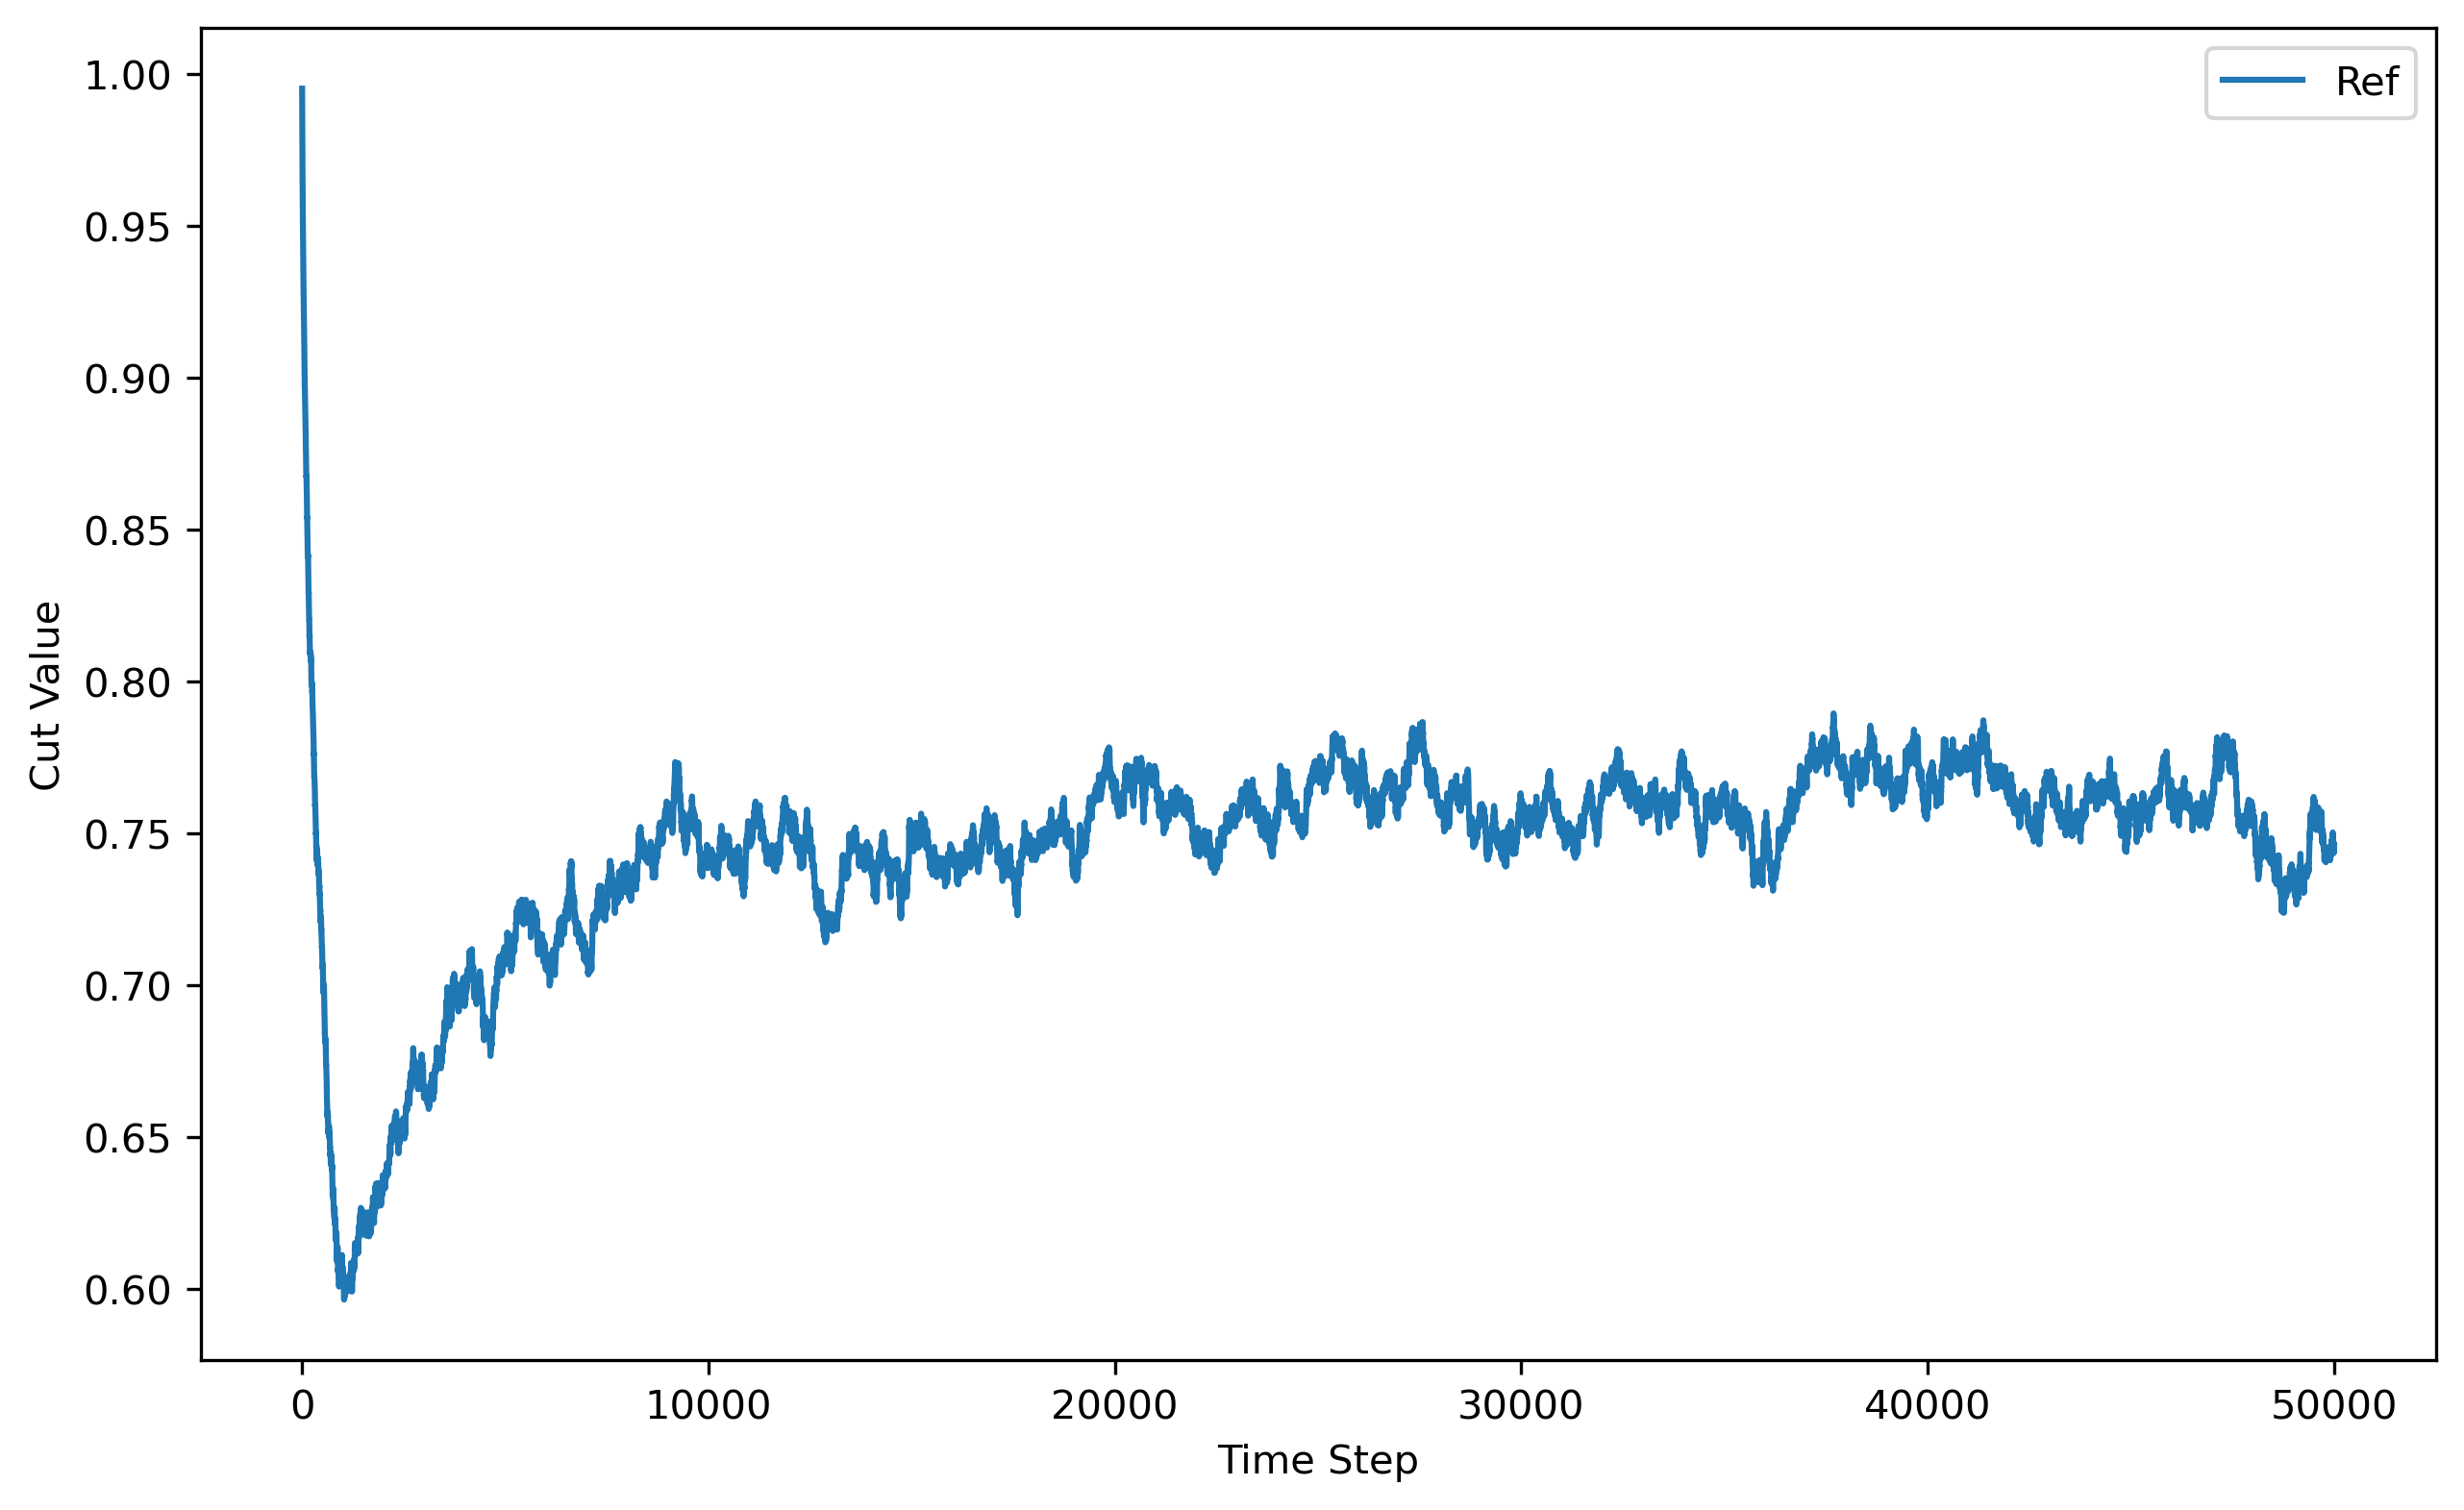

In [399]:
import pandas as pd
import matplotlib.pyplot as plt
fig, ax = plt.subplots(dpi=300, figsize=(10, 6))
ax = sns.lineplot(x=np.arange(len(v3)), y=vc7, label='Ref')
ax.set_ylabel('Cut Value')
# ax.set_ylabel('Degenerate State Overlap')
ax.set_xlabel('Time Step')
# ax.set_yscale('log')
# ax.set_yscale('log')
ax.legend()
# [np.var(i) for i in [v2, v3, v4]]

[15.320681003894864, 13.35701550090274, 20.01044368942356]

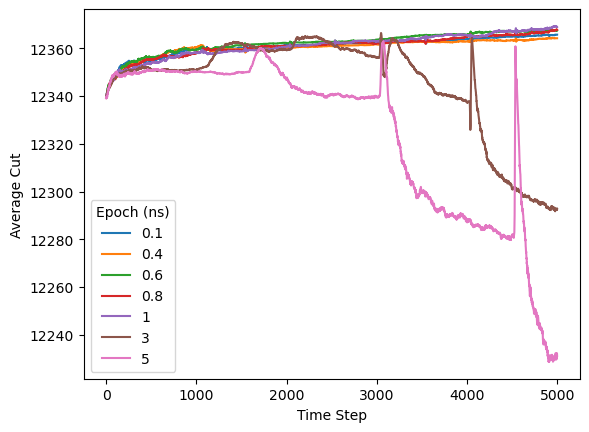

In [383]:
import pandas as pd
import matplotlib.pyplot as plt
# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)
ax = sns.lineplot(x=np.arange(len(v2)), y=v2, label='0.1')
ax = sns.lineplot(x=np.arange(len(v2)), y=v3, label='0.4')
ax = sns.lineplot(x=np.arange(len(v2)), y=v4, label='0.6')
ax = sns.lineplot(x=np.arange(len(v2)), y=v5, label='0.8')
ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='1')
# ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='9')
ax = sns.lineplot(x=np.arange(len(v2)), y=v7, label='3')
ax = sns.lineplot(x=np.arange(len(v2)), y=v8, label='5')
ax.set_ylabel('Average Cut')
ax.set_xlabel('Time Step')
# ax.set_yscale('log')
ax.legend(title='Epoch (ns)')
[np.var(i) for i in [v2, v3, v4]]

[7.544421832489752, 4.514221538602439, 4.668134108786935]

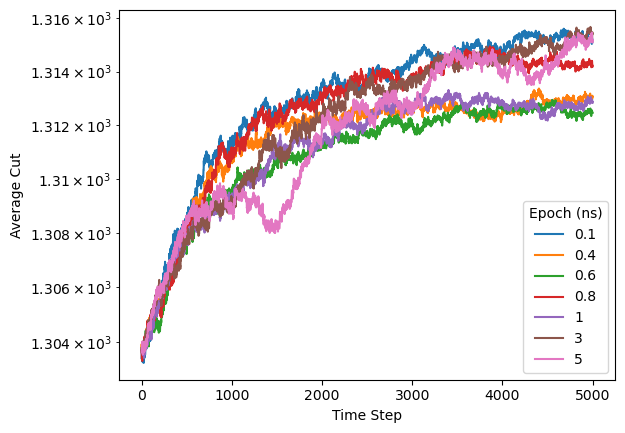

In [318]:
import pandas as pd
import matplotlib.pyplot as plt
# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)
ax = sns.lineplot(x=np.arange(len(v2)), y=v2, label='0.1')
ax = sns.lineplot(x=np.arange(len(v2)), y=v3, label='0.4')
ax = sns.lineplot(x=np.arange(len(v2)), y=v4, label='0.6')
ax = sns.lineplot(x=np.arange(len(v2)), y=v5, label='0.8')
ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='1')
# ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='9')
ax = sns.lineplot(x=np.arange(len(v2)), y=v7, label='3')
ax = sns.lineplot(x=np.arange(len(v2)), y=v8, label='5')
ax.set_ylabel('Average Cut')
ax.set_xlabel('Time Step')
ax.set_yscale('log')
ax.legend(title='Epoch (ns)')
[np.var(i) for i in [v2, v3, v4]]

[255.26218311164962, 9916.599328402368, 8671.075172457173]

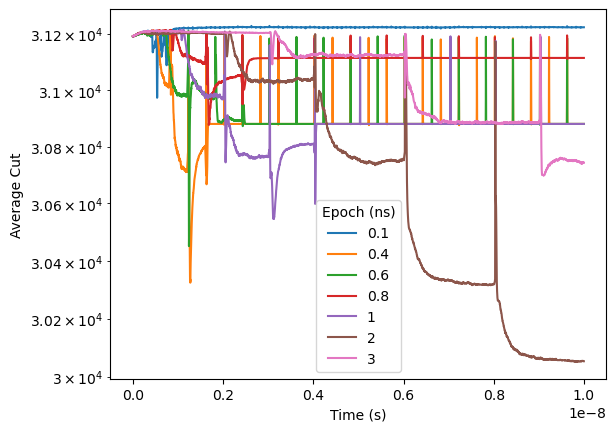

In [226]:
import pandas as pd
import matplotlib.pyplot as plt
# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v2, label='0.1')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v3, label='0.4')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v4, label='0.6')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v5, label='0.8')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v6, label='1')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v7, label='2')
ax = sns.lineplot(x=np.arange(len(v2))*2e-12, y=v8, label='3')
ax.set_ylabel('Average Cut')
ax.set_xlabel('Time (s)')
ax.set_yscale('log')
ax.legend(title='Epoch (ns)')
# sns.lineplot(x=np.arange(len(v2)), y=v2)
# sns.lineplot(x=np.arange(len(v2)), y=v3)
# sns.lineplot(x=np.arange(len(v2)), y=v4)
[np.var(i) for i in [v2, v3, v4]]

[15.489755229164338, 15661.0218680134, 820.8473976637805]

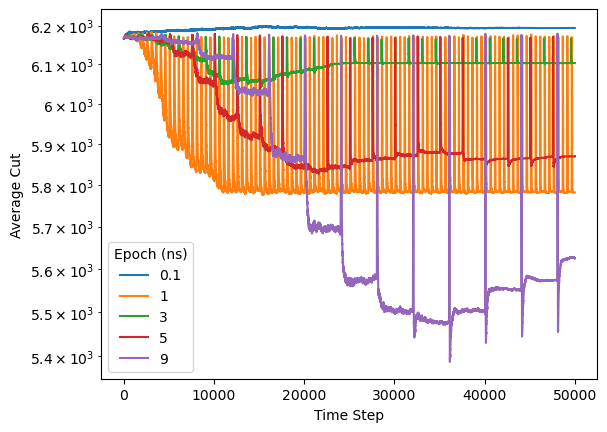

In [150]:
import pandas as pd
import matplotlib.pyplot as plt
# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)
ax = sns.lineplot(x=np.arange(len(v2)), y=v2, label='0.1')
ax = sns.lineplot(x=np.arange(len(v2)), y=v3, label='1')
ax = sns.lineplot(x=np.arange(len(v2)), y=v4, label='3')
ax = sns.lineplot(x=np.arange(len(v2)), y=v5, label='5')
ax = sns.lineplot(x=np.arange(len(v2)), y=v6, label='9')
ax.set_ylabel('Average Cut')
ax.set_xlabel('Time Step')
ax.set_yscale('log')
ax.legend(title='Epoch (ns)')
# sns.lineplot(x=np.arange(len(v2)), y=v2)
# sns.lineplot(x=np.arange(len(v2)), y=v3)
# sns.lineplot(x=np.arange(len(v2)), y=v4)
[np.var(i) for i in [v2, v3, v4]]

2001
2001


100%|██████████| 20000/20000 [00:02<00:00, 8169.11it/s]


[14186.922662677496, 24941.811935937498, 28187.162051639996]

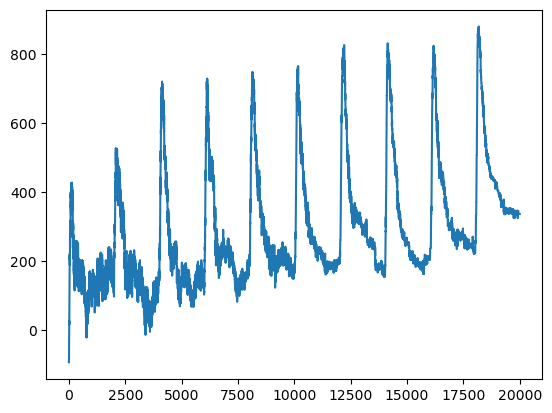

In [139]:
import pandas as pd

# sns.lineplot(x=np.arange(len(v2)), y=vc2-v2)
# sns.lineplot(x=np.arange(len(v2)), y=vc3-v3)

x1, v4, vc4 = concurrent_langevin(G, A, x0, np.array_split(np.arange(G.number_of_nodes()), 4), 1e-7, 5e-12, 1e-8)
sns.lineplot(x=np.arange(len(v2)), y=v4)
# sns.lineplot(x=np.arange(len(v2)), y=v2)
# sns.lineplot(x=np.arange(len(v2)), y=v3)
# sns.lineplot(x=np.arange(len(v2)), y=v4)
[np.var(i) for i in [v2, v3, v4]]